In [1]:
from data_processing import *
pd.options.display.width = 0
#%matplotlib inline

# Set the task and experiment type
task_name = 'swda'

# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [6]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param +'_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param +'_mean_data.csv'))

# Get the max values for each model
vocab_data_max = get_max(vocab_mean_data, exp_param)
print("Best validation accuracy in mean data:")
print(vocab_data_max.loc[[vocab_data_max['val_acc'].idxmax()], ['model_name', 'val_' + exp_param, 'val_acc']])
print("Best test accuracy in mean data:")
print(vocab_data_max.loc[[vocab_data_max['test_acc'].idxmax()], ['model_name', 'test_' + exp_param, 'test_acc', 'f1_micro']])
vocab_data_max

Best validation accuracy in mean data:
  model_name  val_vocab_size   val_acc
7   text cnn            5500  0.756117
Best test accuracy in mean data:
  model_name  test_vocab_size  test_acc  f1_micro
5       lstm             2500  0.729049  0.730449


,model_name,val_vocab_size,val_acc,test_vocab_size,test_acc,f1_micro
0,bi gru,4000,0.731305,8000,0.718470,0.720103
1,bi lstm,8000,0.749769,8000,0.728060,0.729566
2,cnn,2500,0.744975,7500,0.718491,0.719735
3,dcnn,7500,0.751531,8000,0.726971,0.728389
4,gru,8000,0.738904,6500,0.719435,0.720961
5,lstm,7000,0.752472,2500,0.729049,0.730449
6,rcnn,7500,0.743606,7000,0.717692,0.719294
7,text cnn,5500,0.756117,2500,0.728534,0.729958


Plot accuracy of each model per vocabulary size.

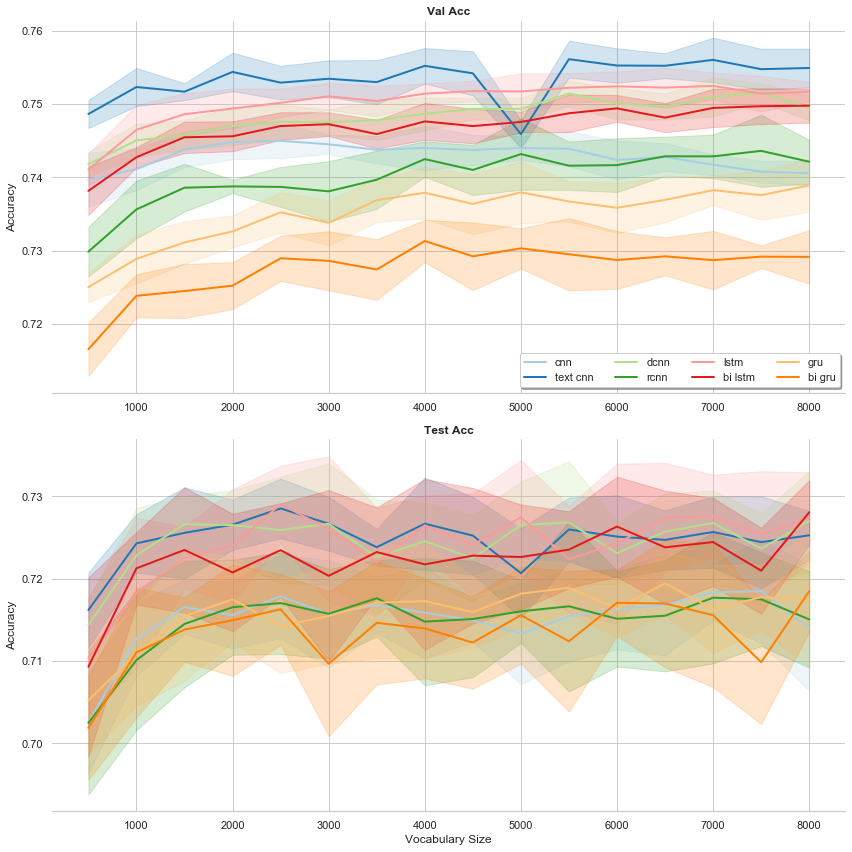

In [3]:
# TODO remove test data
# Get test and validation accuracy for each model
acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
acc_data = acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
acc_data = acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_relplot(acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
                      title='', y_label='Accuracy', x_label='Vocabulary Size',  share_x=False, share_y=False, num_col=1,
                      legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [13]:
# Set the metric to test and statistical significance level
metric = 'val_acc'
sig_level = 0.05

# Run Shaprio-wilks for all models and vocabulary sizes
shapiro_frame = shapiro_wilk_test(vocab_data, exp_param, metric)

if all(p_value > sig_level for p_value in shapiro_frame['p-value']):
    print("All " + exp_param + " are normally distributed.")
else:
    print("The following " + exp_param + " are not normally distributed.")
    print(shapiro_frame.loc[shapiro_frame['p-value'] <= sig_level])

# Run Levene test for equal variance
levene_frame = levene_test(vocab_data, exp_param, metric)

if all(p_value > sig_level for p_value in levene_frame['p-value']):
    print("All models " + exp_param + " have equal variance.")
else:
    print("The following models " + exp_param + " do not have equal variance.")
    print(levene_frame.loc[levene_frame['p-value'] <= sig_level])

levene_frame

The following vocab_size are not normally distributed.
   model_name vocab_size    t-stat   p-value
11        cnn       6000  0.795897  0.012926
23   text cnn       4000  0.825526  0.029553
50       rcnn       1500  0.838140  0.041916
62       rcnn       7500  0.753436  0.003930
76       lstm       6500  0.815659  0.022455
87    bi lstm       4000  0.814240  0.021584
All models vocab_size have equal variance.


,model_name,t-stat,p-value
0,cnn,1.413760,0.148137
1,text cnn,0.766139,0.712889
2,dcnn,0.549283,0.908151
3,rcnn,0.893647,0.572526
4,lstm,0.960897,0.499452
5,bi lstm,0.936507,0.525635
6,gru,0.577683,0.888292
7,bi gru,1.005563,0.452810


Perform ANOVA for each model, comparing different vocabulary size groups,
followed by Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmap shows Tukey-HSD results for each model.

In [7]:
# Run ANOVA
anova_frame = anova_test(vocab_data, exp_param, metric)

if all(p_value <= sig_level for p_value in anova_frame['PR(>F)']):
    print("All models have significant p-values when comparing " + exp_param + " groups.")
else:
    print("The following models do not have significant p-values when comparing " + exp_param + " groups.")
    print(anova_frame.loc[anova_frame['PR(>F)'] > sig_level])

anova_frame

All models have significant p-values when comparing vocab_size groups.


,F,PR(>F),df,eta_sq,mean_sq,omega_sq,sum_sq
cnn,5.326351,2.025392e-08,15.0,0.356842,0.000028,0.288558,0.000416
text cnn,12.568081,1.593483e-19,15.0,0.566945,0.000076,0.520270,0.001136
dcnn,15.746608,1.838878e-23,15.0,0.621251,0.000065,0.580272,0.000982
rcnn,10.350516,1.795819e-16,15.0,0.518809,0.000125,0.467124,0.001876
lstm,17.218715,3.891193e-25,15.0,0.642041,0.000086,0.603254,0.001293
bi lstm,18.407561,1.987861e-26,15.0,0.657235,0.000089,0.620055,0.001336
gru,14.953782,1.597458e-22,15.0,0.609022,0.000148,0.566756,0.002217
bi gru,10.018167,5.446340e-16,15.0,0.510658,0.000128,0.458128,0.001918


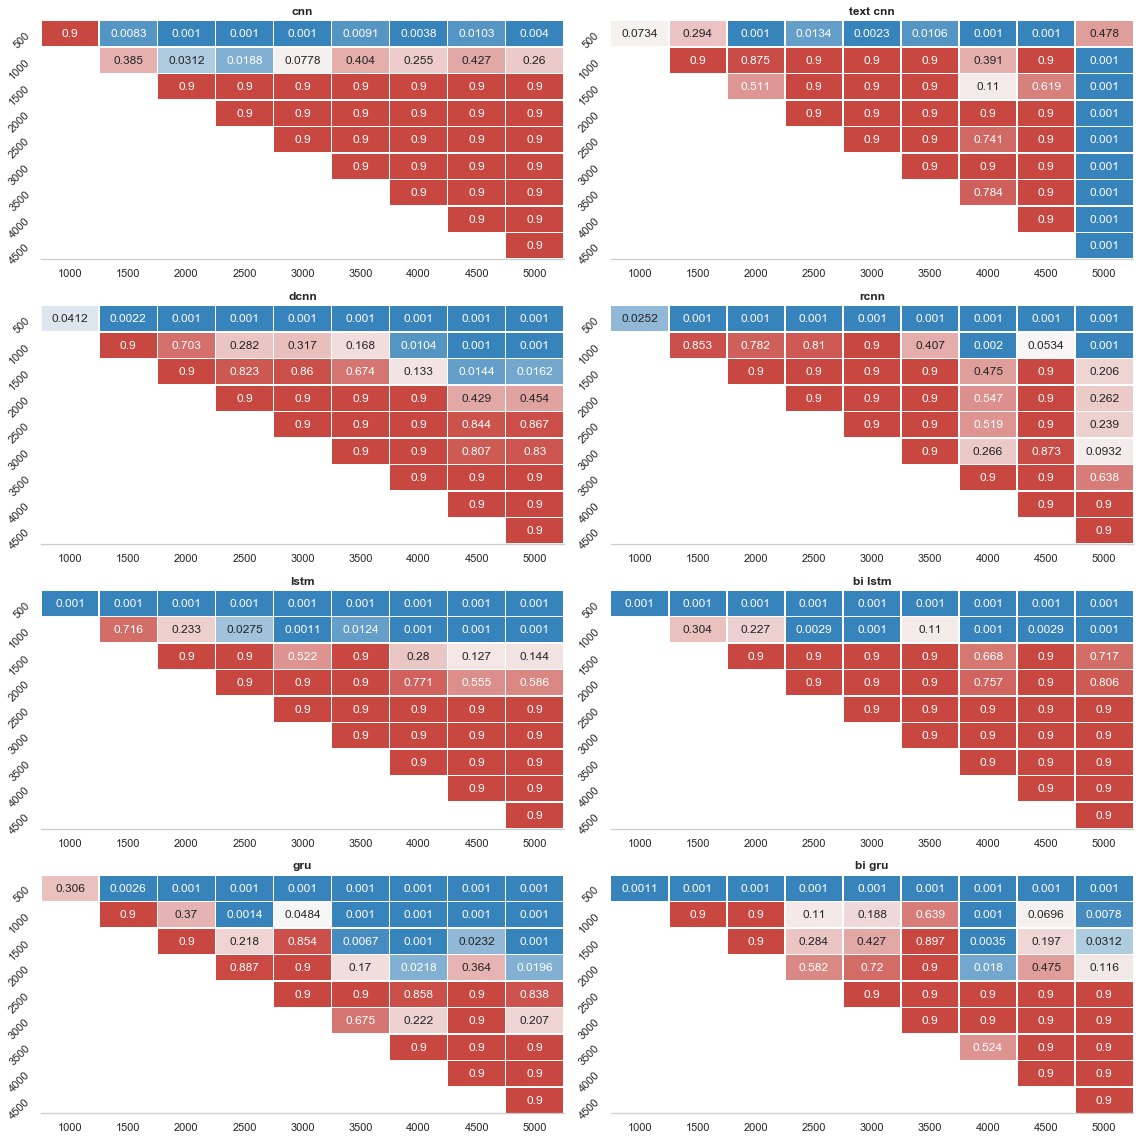

In [8]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric)

# Drop the un-needed columns and generate heatmaps
tukey_frame = tukey_frame.drop(columns=['meandiff', 'lower', 'upper', 'reject'], axis=1)
# Remove vocab_size > 5000 to make plots nicer
tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 5000) | (tukey_frame.group2 > 5000)].index, inplace=True)

g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))